In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from importlib import reload

In [2]:
import particle_decoding as pd

In [3]:
reload(pd)

<module 'particle_decoding' from '/Users/jim2/bin/libVAE/particle_decoding.py'>

## Transformations

In [4]:
test_coords = np.array([[[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]],
                        [[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]]])

In [5]:
pd.identity_transform(test_coords)

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[ 1. ,  1. ,  1. ],
        [-1. ,  1. ,  0. ],
        [ 0.5,  0.5,  1. ]],

       [[ 1. ,  1. ,  1. ],
        [-1. ,  1. ,  0. ],
        [ 0.5,  0.5,  1. ]]])>

In [6]:
pd.spherical_transform(test_coords)

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[1.73205081, 0.78539816, 0.95531662],
        [1.41421356, 2.35619449, 1.57079633],
        [1.22474487, 0.78539816, 0.61547971]],

       [[1.73205081, 0.78539816, 0.95531662],
        [1.41421356, 2.35619449, 1.57079633],
        [1.22474487, 0.78539816, 0.61547971]]])>

In [7]:
pd.spherical_transform(test_coords, dist_sq=tf.reduce_sum(test_coords * test_coords, axis=-1))

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[1.73205081, 0.78539816, 0.95531662],
        [1.41421356, 2.35619449, 1.57079633],
        [1.22474487, 0.78539816, 0.61547971]],

       [[1.73205081, 0.78539816, 0.95531662],
        [1.41421356, 2.35619449, 1.57079633],
        [1.22474487, 0.78539816, 0.61547971]]])>

In [8]:
pd.spherical_transform(pd.spherical_transform(test_coords), reverse=True)

<tf.Tensor: shape=(2, 3, 3), dtype=float64, numpy=
array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [-1.00000000e+00,  1.00000000e+00,  8.65956056e-17],
        [ 5.00000000e-01,  5.00000000e-01,  1.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [-1.00000000e+00,  1.00000000e+00,  8.65956056e-17],
        [ 5.00000000e-01,  5.00000000e-01,  1.00000000e+00]]])>

## Masking by distance

In [9]:
test_coords = np.array([[[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]],
                        [[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]]])

ref_coords = np.array([[[0.0, 0.0, 0.0]],
                       [[0.0, 0.0, 1.0]]])

In [10]:
distance_mask = pd.DistanceMask()

In [11]:
distance_mask(ref_coords, test_coords, k_neighbors=2)

(<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
 array([[[ 0.5,  0.5,  1. ],
         [-1. ,  1. ,  0. ]],
 
        [[ 0.5,  0.5,  0. ],
         [ 1. ,  1. ,  0. ]]])>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[2, 1],
        [2, 0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.5, 2. ],
        [0.5, 2. ]])>)

In [12]:
local_coords, near_inds, dist_sq = distance_mask(ref_coords, test_coords, k_neighbors=2)
pd.spherical_transform(local_coords, dist_sq=dist_sq)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[1.22474487, 0.78539816, 0.61547971],
        [1.41421356, 2.35619449, 1.57079633]],

       [[0.70710678, 0.78539816, 1.57079633],
        [1.41421356, 0.78539816, 1.57079633]]])>

In [13]:
#Need to also test if ref included in input coordinates
ref_coords = np.array([[[-1.0, 1.0, 0.0]],
                       [[1.0, 1.0, 1.0]]])

distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=True)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[ 1.5, -0.5,  1. ]],
 
        [[-0.5, -0.5,  0. ]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[2],
        [2]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[3.5],
        [0.5]])>)

In [14]:
distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=False)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[0., 0., 0.]],
 
        [[0., 0., 0.]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[-0.],
        [-0.]])>)

In [15]:
#Now try distances with a periodic simulation box
test_coords = np.array([[[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]],
                        [[1.0, 1.0, 1.0],
                        [-1.0, 1.0, 0.0],
                        [0.5, 0.5, 1.0]]])

ref_coords = np.array([[[0.0, 0.0, 0.0]],
                       [[0.0, 0.0, 1.0]]])

distance_mask = pd.DistanceMask(box_lengths=np.array([3.0, 3.0, 3.0]))

In [16]:
distance_mask(ref_coords, test_coords, k_neighbors=2)

(<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
 array([[[ 0.5,  0.5,  1. ],
         [-1. ,  1. ,  0. ]],
 
        [[ 0.5,  0.5,  0. ],
         [ 1. ,  1. ,  0. ]]])>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[2, 1],
        [2, 0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.5, 2. ],
        [0.5, 2. ]])>)

In [17]:
local_coords, near_inds, dist_sq = distance_mask(ref_coords, test_coords, k_neighbors=2)
pd.spherical_transform(local_coords, dist_sq=dist_sq)

<tf.Tensor: shape=(2, 2, 3), dtype=float64, numpy=
array([[[1.22474487, 0.78539816, 0.61547971],
        [1.41421356, 2.35619449, 1.57079633]],

       [[0.70710678, 0.78539816, 1.57079633],
        [1.41421356, 0.78539816, 1.57079633]]])>

In [18]:
#Need to also test if ref included in input coordinates
ref_coords = np.array([[[-1.0, 1.0, 0.0]],
                       [[1.0, 1.0, 1.0]]])

distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=True)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[-1. ,  0. ,  1. ]],
 
        [[-0.5, -0.5,  0. ]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[0],
        [2]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[2. ],
        [0.5]])>)

In [19]:
distance_mask(ref_coords, test_coords, k_neighbors=1, ref_included=False)

(<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
 array([[[0., 0., 0.]],
 
        [[0., 0., 0.]]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[-0.],
        [-0.]])>)

## Creating probability distributions

In [20]:
params = np.array([[[[0.0, 1.0], [10.0, 1.0], [-10.0, 1.0]],
                    [[0.0, 1.0], [0.0, 2.0], [0.0, 10.0]],
                    [[5.0, 1.0], [5.0, 2.0], [5.0, 10.0]]],
                   [[[0.0, 1.0], [-10.0, 1.0], [10.0, 1.0]],
                    [[0.0, 10.0], [0.0, 2.0], [0.0, 1.0]],
                    [[-5.0, 10.0], [-5.0, 2.0], [-5.0, 1.0]]]])

dist_list = [tfp.distributions.Normal]*3
param_trans = [lambda x, y: [x, y]]*3

In [21]:
joint_dist = pd.create_dist(params, dist_list, param_trans)

In [22]:
sample = tf.stack(joint_dist.sample(), axis=-1)
print(sample)

tf.Tensor(
[[[  0.23292805  12.04493878  -7.83952683]
  [ -1.18649911   0.29522801   8.1184565 ]
  [  3.6817518    3.12434873  -7.36771411]]

 [[ -0.35549221 -11.37528835  10.143287  ]
  [  2.59537173  -0.31698058   0.34192527]
  [ -6.74109612  -5.2156615   -4.37855254]]], shape=(2, 3, 3), dtype=float64)


In [23]:
joint_dist.log_prob(tf.unstack(sample, axis=-1))

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[-7.2086528 , -6.79687957, -7.82599726],
       [-3.77597756, -5.85724368, -5.96661716]])>

In [24]:
np.sum(-0.5*((sample[-1, 1, :] - params[-1, 1, :, 0])**2)/(params[-1, 1, :, 1]**2) - np.log(params[-1, 1, :, 1]) - 0.5*np.log(2.0*np.pi))

-5.857243675854347

## Solvation neural networks

In [18]:
#Input can be solute or solvent coordinates, with extra_inputs being the other
#Start by testing without augmented input (only relevant for first network to predict layer of solvent for first solute)
solute_net = pd.SolvationNet((8, 3), out_event_dims=2, hidden_dim=50, n_hidden=3, augment_input=False)

In [19]:
solute_coords = tf.random.normal((1, 2, 3))

In [20]:
params, shifts = solute_net(solute_coords)
print(params, shifts)

tf.Tensor(
[[[[-0.04026603  0.06635774]
   [ 0.00865363  0.05654437]
   [ 0.12707569 -0.0976495 ]]

  [[-0.02559419 -0.17506926]
   [ 0.01768472 -0.06815599]
   [-0.02989509 -0.1405346 ]]

  [[-0.00119899  0.12990305]
   [ 0.04059143 -0.00124714]
   [-0.07842124 -0.01281727]]

  [[ 0.14159317 -0.00845538]
   [ 0.06832756 -0.11636686]
   [-0.01995266 -0.01511041]]

  [[-0.06345326 -0.09542494]
   [-0.06814086  0.07653265]
   [-0.02817912 -0.0803067 ]]

  [[-0.15569405  0.135096  ]
   [ 0.16346586  0.0162905 ]
   [-0.01236154 -0.12380844]]

  [[ 0.04417741 -0.13837376]
   [-0.07332565  0.03274022]
   [-0.00406992  0.03884795]]

  [[-0.04078941 -0.06713891]
   [ 0.07157004  0.02342764]
   [ 0.024635   -0.11893216]]]], shape=(1, 8, 3, 2), dtype=float32) tf.Tensor(
[[[[ 0.6155804  -0.28173566]
   [ 0.54871666  0.12624551]
   [-0.8505431  -0.0303981 ]]

  [[ 0.14163643 -0.08169727]
   [-0.09798966 -0.41980287]
   [ 0.77209216 -0.383365  ]]

  [[ 0.2281578  -1.1943618 ]
   [-0.4644335  -0.172

In [21]:
dist = pd.create_dist(params + shifts, [tfp.distributions.Normal]*3, [lambda x, y: [x, tf.math.exp(0.5*y)]]*3)
sample = tf.stack(dist.sample(), axis=-1)
print(sample)

tf.Tensor(
[[[ 2.1699956e-01  4.5875889e-01 -2.2935636e+00]
  [-1.3338082e-01  7.8442675e-01  5.7162124e-01]
  [-4.3318748e-02 -1.2195898e+00  4.1211736e-01]
  [-2.8662455e-01  3.2139206e-01 -2.9861003e-02]
  [ 5.5649698e-01 -1.0361325e+00  6.5015066e-01]
  [-3.1128103e-01 -6.5873790e-01  7.5871271e-01]
  [ 4.0206811e-01  1.8926889e-02  1.1216359e+00]
  [-1.4565587e-03 -6.9444191e-01 -1.0072081e+00]]], shape=(1, 8, 3), dtype=float32)


In [22]:
#First set of 3 (first particle) should not change shifts, even with different input due to autoregressive
#All others should change, though
new_shifts = solute_net(solute_coords, sampled_input=sample)
print(new_shifts)

tf.Tensor(
[[[[ 0.6155804  -0.28173566]
   [ 0.54871666  0.12624551]
   [-0.8505431  -0.0303981 ]]

  [[ 0.14447203 -0.07809608]
   [-0.10025837 -0.4221053 ]
   [ 0.7672082  -0.3990788 ]]

  [[ 0.23964569 -1.2084142 ]
   [-0.454589   -0.2004633 ]
   [ 0.05651975 -0.5359682 ]]

  [[ 0.0514506  -0.43772367]
   [ 0.23361844 -0.71113807]
   [-0.35569954 -0.1871368 ]]

  [[-0.33782703  0.04703863]
   [-0.28002247  0.15017572]
   [-0.1205371  -0.13489732]]

  [[-0.2712658   0.2764485 ]
   [ 0.3420166  -0.0141978 ]
   [ 0.5821911   0.6719755 ]]

  [[ 0.79519844  0.2599162 ]
   [ 0.4123389   0.28767776]
   [ 0.14815727 -0.38578933]]

  [[-0.1569935   0.2003231 ]
   [-0.2622243  -0.75650036]
   [-0.29630956  0.03960833]]]], shape=(1, 8, 3, 2), dtype=float32)


In [23]:
#And now with solvent inputs (remember, could flip if wanted)
solute_net_solv = pd.SolvationNet((8, 3), out_event_dims=2, hidden_dim=50, n_hidden=3, augment_input=True)

In [24]:
solvent_coords = tf.random.normal((1, 6, 3))

In [25]:
params, shifts = solute_net_solv(solute_coords, extra_coords=solvent_coords)
print(params, shifts)

tf.Tensor(
[[[[-9.39147025e-02 -1.11829191e-02]
   [-1.58560038e-01 -5.42829260e-02]
   [ 2.20027208e-01 -1.15036964e-04]]

  [[ 3.34971756e-01 -3.92439365e-02]
   [ 5.01214147e-01 -1.11332513e-01]
   [ 3.43021423e-01  2.30864495e-01]]

  [[ 3.25590342e-01 -1.64320469e-02]
   [ 2.28199854e-01 -7.32630938e-02]
   [ 1.42923534e-01  8.93578976e-02]]

  [[ 1.95768297e-01  1.55813359e-02]
   [ 1.85524032e-01  1.88313991e-01]
   [ 1.35070831e-01  2.85843879e-01]]

  [[-1.03760086e-01 -1.02752343e-01]
   [-1.03736371e-01 -3.84202600e-02]
   [-4.01916325e-01 -2.41893418e-02]]

  [[-1.93070993e-01 -2.74155796e-01]
   [-1.24572672e-01  1.41575620e-01]
   [ 1.66444644e-01  1.24665827e-01]]

  [[ 2.41011083e-01 -7.98236877e-02]
   [ 4.22024131e-01 -1.57031894e-01]
   [ 2.68806033e-02  1.62630484e-01]]

  [[-2.15265974e-01 -1.02887511e-01]
   [-3.45921040e-01  1.29817694e-01]
   [-1.48277164e-01 -1.51440203e-02]]]], shape=(1, 8, 3, 2), dtype=float32) tf.Tensor(
[[[[ 0.43470302  0.8693577 ]
   [ 0.9

In [26]:
dist = pd.create_dist(params + shifts, [tfp.distributions.Normal]*3, [lambda x, y: [x, tf.math.exp(0.5*y)]]*3)
sample = tf.stack(dist.sample(), axis=-1)
print(sample)

tf.Tensor(
[[[ 1.2535477   0.39102405  1.045542  ]
  [ 1.4180945   0.7737137  -2.0428135 ]
  [-0.9153837   1.7848072  -0.01868257]
  [ 0.9056382  -0.11129546  6.2020545 ]
  [ 1.5298359   0.06110591 -0.3201016 ]
  [-0.7677171   1.6765904   0.49761817]
  [ 2.3504424   0.8721149   0.11302093]
  [ 1.151407   -0.9064736   0.76009154]]], shape=(1, 8, 3), dtype=float32)


In [27]:
new_shifts = solute_net_solv(solute_coords, extra_coords=solvent_coords, sampled_input=sample)
print(new_shifts)

tf.Tensor(
[[[[ 0.43470302  0.8693577 ]
   [ 0.9038086  -0.24054411]
   [ 0.1700334   1.2178609 ]]

  [[ 0.5396937   0.15752983]
   [-0.01673118  0.2300089 ]
   [-0.5317029   0.6793797 ]]

  [[-0.36513576 -0.2520276 ]
   [ 0.9552163  -0.0767924 ]
   [ 0.15382957  0.05679472]]

  [[ 0.68007344 -0.23798972]
   [ 0.22492209 -0.75928044]
   [ 0.04151265  2.1838083 ]]

  [[ 1.0967298   0.9649513 ]
   [-0.43352816 -0.6251669 ]
   [ 0.24946606 -1.00652   ]]

  [[ 0.01301058 -0.44397745]
   [-0.5956212   1.0112463 ]
   [ 0.27820057 -0.8975022 ]]

  [[-0.41419438  1.0217947 ]
   [-0.11994515  0.82537574]
   [ 0.14000034  0.09605041]]

  [[ 0.8487425  -1.2920828 ]
   [ 0.18138716 -0.6934447 ]
   [ 0.60231936 -1.8705175 ]]]], shape=(1, 8, 3, 2), dtype=float32)


In [28]:
#Now that it's been called (so built) with extra_coords provided, must provide always with this layer
new_shifts = solute_net_solv(solute_coords, sampled_input=sample)
print(new_shifts)

ValueError: Input 0 of layer dense_41 is incompatible with the layer: expected axis -1 of input shape to have value 24 but received input with shape (1, 6)

In [29]:
#Now pretend we're working with a central solvent particle and adding one more
#(conditioned on other solutes and solvent already around)
solvent_net = pd.SolvationNet((1, 3), out_event_dims=2, hidden_dim=50, n_hidden=3, augment_input=True)

In [30]:
params, shifts = solvent_net(solvent_coords, extra_coords=solute_coords)
print(params, shifts)

tf.Tensor(
[[[[ 0.20347501 -0.29772514]
   [-0.68237895  0.11383507]
   [-0.31507257  0.33063942]]]], shape=(1, 1, 3, 2), dtype=float32) tf.Tensor(
[[[[-1.3573248  1.928788 ]
   [-1.6333238 -1.0373075]
   [ 1.593895   2.369074 ]]]], shape=(1, 1, 3, 2), dtype=float32)


## Decimation encoding

In [4]:
test_coords = np.random.normal(size=(2, 6, 3))
test_coords

array([[[-5.30809459e-01,  2.19146796e-01,  1.73400153e+00],
        [ 5.17440507e-01,  1.03737511e+00,  1.66440905e-03],
        [ 7.28517643e-01, -4.91708700e-01, -1.63493167e+00],
        [ 1.10097593e-01,  9.85105114e-01, -2.45173674e+00],
        [ 4.54030335e-01,  1.50116812e+00,  1.83013749e+00],
        [-1.87603503e+00,  1.16883956e+00,  1.40619525e-01]],

       [[ 7.31222222e-01,  8.53708357e-02,  2.64698786e-01],
        [-1.42425341e+00,  5.75442375e-02,  1.54024570e+00],
        [ 1.83842377e+00, -1.00491523e+00, -1.17380901e+00],
        [ 5.65067710e-02,  7.15437366e-01, -9.13192408e-01],
        [-1.34264658e+00,  1.39053701e+00,  5.10411894e-01],
        [ 3.21112297e-01, -6.94571306e-01, -5.00629142e-01]]])

In [5]:
cg_mask = np.array([True, False, True, False, True, False])
encoder = pd.DecimationEncoder(cg_mask)

In [6]:
encoder(test_coords)

(<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[-0.53080946,  0.2191468 ,  1.7340015 ],
         [ 0.72851765, -0.4917087 , -1.6349317 ],
         [ 0.45403033,  1.5011681 ,  1.8301375 ]],
 
        [[ 0.7312222 ,  0.08537084,  0.26469877],
         [ 1.8384237 , -1.0049152 , -1.173809  ],
         [-1.3426466 ,  1.390537  ,  0.5104119 ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[ 5.17440498e-01,  1.03737509e+00,  1.66440906e-03],
         [ 1.10097595e-01,  9.85105097e-01, -2.45173669e+00],
         [-1.87603498e+00,  1.16883957e+00,  1.40619531e-01]],
 
        [[-1.42425346e+00,  5.75442389e-02,  1.54024565e+00],
         [ 5.65067716e-02,  7.15437353e-01, -9.13192391e-01],
         [ 3.21112305e-01, -6.94571316e-01, -5.00629127e-01]]],
       dtype=float32)>)

In [7]:
encoder = pd.DecimationEncoder(cg_mask, identical_randomize=True)
encoder(test_coords)

(<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[-0.53080946,  0.2191468 ,  1.7340015 ],
         [ 0.45403033,  1.5011681 ,  1.8301375 ],
         [ 0.72851765, -0.4917087 , -1.6349317 ]],
 
        [[-1.3426466 ,  1.390537  ,  0.5104119 ],
         [ 1.8384237 , -1.0049152 , -1.173809  ],
         [ 0.7312222 ,  0.08537084,  0.26469877]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[ 5.17440498e-01,  1.03737509e+00,  1.66440906e-03],
         [ 1.10097595e-01,  9.85105097e-01, -2.45173669e+00],
         [-1.87603498e+00,  1.16883957e+00,  1.40619531e-01]],
 
        [[-1.42425346e+00,  5.75442389e-02,  1.54024565e+00],
         [ 5.65067716e-02,  7.15437353e-01, -9.13192391e-01],
         [ 3.21112305e-01, -6.94571316e-01, -5.00629127e-01]]],
       dtype=float32)>)

## Solute decoding

In [8]:
solute_decoder = pd.SoluteDecoder(3,
                             box_lengths=np.array([3.0, 3.0, 3.0]),
                             k_solute_neighbors=3,
                             k_solvent_neighbors=3,
                             name='solutedecoder')

In [9]:
solute_coords = tf.random.uniform((2, 5, 3), minval=-1.5, maxval=1.5)

In [10]:
sample_out, params_out, ref_out, unused_data = solute_decoder(solute_coords)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 15, 3) (2, 15, 3, 2) (2, 15, 3)


In [11]:
print(unused_data)

None


In [12]:
sample_out - ref_out

<tf.Tensor: shape=(2, 15, 3), dtype=float32, numpy=
array([[[ 2.5025406 ,  0.6589569 , -1.7768145 ],
        [ 1.0746843 , -3.0423112 , -0.28193045],
        [ 1.5332494 ,  2.4603364 ,  0.71024066],
        [ 0.44212192, -1.4825355 , -0.67404294],
        [ 1.604381  , -2.4046936 ,  0.31524003],
        [-2.0481632 ,  0.7133956 , -0.5803141 ],
        [ 0.94803417, -1.3493259 ,  1.6908252 ],
        [ 0.7081678 ,  0.43034476,  1.7335112 ],
        [ 1.4580549 , -2.1528296 , -1.2116672 ],
        [ 1.8005636 ,  1.476004  , -0.15911543],
        [-0.13897634,  0.5583998 , -1.2291552 ],
        [-1.9183363 ,  0.11193442, -5.5155416 ],
        [-2.1530612 , -1.3221755 , -0.98760295],
        [ 2.206042  ,  1.3985178 ,  0.42632818],
        [ 0.13915808, -1.5938351 ,  2.511819  ]],

       [[-0.03171206, -0.21234751, -2.5047827 ],
        [ 1.7761121 ,  2.7318883 ,  0.6698798 ],
        [ 3.8825488 ,  1.4880929 ,  3.533907  ],
        [ 0.1266557 ,  0.9786316 , -1.1079458 ],
        [ 1.582

In [13]:
params_out

<tf.Tensor: shape=(2, 15, 3, 2), dtype=float32, numpy=
array([[[[ 0.7367577 ,  0.15908109],
         [ 0.64646727,  0.39993557],
         [-1.1520584 ,  0.2756362 ]],

        [[ 0.6668179 ,  0.15133965],
         [-0.95975995, -0.5060498 ],
         [ 0.5553362 , -0.289247  ]],

        [[ 0.9369042 ,  0.16585995],
         [ 0.83952993, -0.430883  ],
         [-0.11184888, -0.7773482 ]],

        [[ 0.8229774 , -2.0398414 ],
         [-0.35929388,  1.2136021 ],
         [-0.8078441 , -0.73725796]],

        [[-0.09216685,  1.7052109 ],
         [-0.93107283, -0.27768978],
         [ 0.6291711 , -0.02773156]],

        [[-0.57925683, -0.29614398],
         [ 0.31118706, -1.4406202 ],
         [ 0.38552815,  1.574676  ]],

        [[-0.32631633, -0.9876682 ],
         [-0.8725254 ,  0.54887396],
         [ 0.5443903 ,  0.55576956]],

        [[ 0.11226097,  0.9593228 ],
         [ 0.65829694,  1.2280747 ],
         [ 0.93928796,  0.1096548 ]],

        [[ 0.39807558, -0.18737411],
    

In [14]:
#For convenience, added log_prob function to decoder
solute_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 15), dtype=float32, numpy=
array([[ -4.652047 ,  -6.571372 ,  -5.1424513,  -2.7388906,  -5.2022243,
         -4.564644 ,  -5.438075 ,  -4.2636194,  -4.7729874,  -3.3881638,
         -4.9461613, -10.628631 ,  -4.185979 ,  -3.1024797,  -6.598133 ],
       [ -5.774696 ,  -5.4097853,  -5.9448924,  -3.5319428,  -4.969192 ,
         -4.410301 ,  -5.51233  ,  -5.5947275,  -7.1541414,  -5.7216434,
         -3.4679637,  -4.570555 ,  -6.4606757,  -4.3905144,  -5.6330223]],
      dtype=float32)>

In [15]:
#Above tested generation, now test if have training data
training_data = tf.random.normal((2, 60, 3))

In [16]:
sample_out, params_out, ref_out, unused_data = solute_decoder(solute_coords, train_data=training_data)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 15, 3) (2, 15, 3, 2) (2, 15, 3)


In [17]:
training_data

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 0.63617706,  0.99982184,  0.65069765],
        [ 1.1368322 , -0.6576145 ,  0.00774881],
        [ 0.81263083, -1.0013909 , -0.4298057 ],
        [ 0.8920894 , -0.37649336,  1.039691  ],
        [ 1.475917  , -0.2696754 ,  0.33555877],
        [-0.7704421 ,  0.24486883,  0.49726516],
        [ 1.567594  , -0.8762384 ,  1.5807273 ],
        [ 1.6575382 ,  0.9055635 ,  0.3279133 ],
        [-0.10101566, -0.75675255, -1.6092144 ],
        [ 0.33152428,  0.31850398, -0.46462354],
        [ 2.0502062 ,  0.14019853, -0.97057056],
        [ 0.9349071 , -0.23838201, -1.0166008 ],
        [ 0.1950663 , -0.45252758,  0.82405955],
        [-0.8744931 , -0.6216661 , -0.7281131 ],
        [ 0.00870624,  0.98219484,  0.20292524],
        [ 0.08257237,  0.621076  , -0.26470247],
        [ 0.38204312, -1.3989345 , -1.1493708 ],
        [ 0.61922777,  0.68004495, -1.7945309 ],
        [ 0.01390538, -0.36557105,  1.4270495 ],
        [-0.27316

In [18]:
unused_data

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[ 0.63617706,  0.99982184,  0.65069765],
        [ 1.1368322 , -0.6576145 ,  0.00774881],
        [ 0.81263083, -1.0013909 , -0.4298057 ],
        [ 0.8920894 , -0.37649336,  1.039691  ],
        [ 1.475917  , -0.2696754 ,  0.33555877],
        [-0.7704421 ,  0.24486883,  0.49726516],
        [ 1.567594  , -0.8762384 ,  1.5807273 ],
        [ 1.6575382 ,  0.9055635 ,  0.3279133 ],
        [ 0.33152428,  0.31850398, -0.46462354],
        [ 0.9349071 , -0.23838201, -1.0166008 ],
        [ 0.1950663 , -0.45252758,  0.82405955],
        [ 0.00870624,  0.98219484,  0.20292524],
        [ 0.08257237,  0.621076  , -0.26470247],
        [-0.27316463,  0.7468503 ,  0.73169106],
        [-1.140056  , -0.40520406,  0.7185122 ],
        [ 0.6812267 , -0.7442538 , -2.3036356 ],
        [-2.0877848 ,  0.02813849,  0.9464839 ],
        [ 0.34645405,  1.0303977 , -1.2395983 ],
        [ 0.3759164 , -0.02331201,  1.0726577 ],
        [-2.45298

In [19]:
sample_out

<tf.Tensor: shape=(2, 15, 3), dtype=float32, numpy=
array([[[-0.49997967,  2.0910196 , -2.8112059 ],
        [ 0.06066722,  0.6654792 , -0.98144263],
        [-0.10101569,  2.2432475 , -1.6092144 ],
        [-0.3841231 , -0.6061589 , -0.01282859],
        [-0.59518737, -1.2618537 , -0.42947567],
        [-0.4670125 , -1.9650378 ,  1.4497395 ],
        [ 0.01390538, -0.36557102,  1.4270495 ],
        [ 0.8511333 ,  0.63202345,  1.8897674 ],
        [-0.31509626, -1.8287979 ,  0.6821496 ],
        [ 0.13285357,  0.85507566, -0.35199687],
        [-2.380772  ,  0.68004495, -1.7945309 ],
        [-0.74799657,  1.0009992 ,  0.24936205],
        [-0.9497938 ,  0.14019853, -0.97057056],
        [ 0.38204312,  1.6010654 , -1.1493708 ],
        [-0.8744931 , -0.6216661 , -0.7281131 ]],

       [[-0.95127636, -0.10337806, -0.92880464],
        [-1.157679  , -0.30832636, -1.5420673 ],
        [ 1.0348504 , -0.75640935, -0.00560963],
        [ 0.18144435, -0.49204668,  1.110204  ],
        [ 0.493

In [20]:
sample_out - ref_out

<tf.Tensor: shape=(2, 15, 3), dtype=float32, numpy=
array([[[ 0.31689352,  0.8056178 , -1.6672087 ],
        [ 0.8775404 , -0.61992264,  0.16255456],
        [ 0.7158575 ,  0.9578457 , -0.46521723],
        [ 0.53355575,  0.41811055, -1.0650942 ],
        [ 0.32249147, -0.23758423, -1.4817413 ],
        [ 0.45066634, -0.94076836,  0.3974738 ],
        [ 0.07310709, -0.5366123 ,  0.19719517],
        [ 0.910335  ,  0.4609822 ,  0.65991306],
        [-0.25589454, -1.9998392 , -0.54770476],
        [ 0.9788813 ,  0.5353846 ,  0.38188878],
        [-1.5347444 ,  0.3603539 , -1.0606452 ],
        [ 0.09803116,  0.68130815,  0.9832477 ],
        [-0.59674287, -0.5063402 , -0.8215585 ],
        [ 0.7350941 ,  0.95452666, -1.0003587 ],
        [-0.5214422 , -1.2682048 , -0.579101  ]],

       [[-0.16708678,  1.091226  ,  0.55221856],
        [-0.37348938,  0.8862777 , -0.0610441 ],
        [ 1.81904   ,  0.4381947 ,  1.4754136 ],
        [-0.36470848, -0.3684784 ,  0.14014602],
        [-0.052

In [21]:
params_out

<tf.Tensor: shape=(2, 15, 3, 2), dtype=float32, numpy=
array([[[[ 7.3675770e-01,  1.5908109e-01],
         [ 6.4646727e-01,  3.9993557e-01],
         [-1.1520584e+00,  2.7563620e-01]],

        [[ 6.3332176e-01,  2.3005317e-01],
         [-9.5795059e-01, -6.1167032e-01],
         [ 4.1234428e-01, -2.2147402e-01]],

        [[ 7.8883141e-01,  1.7235281e-01],
         [ 7.8247464e-01, -5.7825500e-01],
         [-1.6691986e-01, -9.2370403e-01]],

        [[ 5.4799473e-01,  3.7611896e-01],
         [ 6.2588972e-01,  5.9746218e-01],
         [-8.5266125e-01, -9.6293998e-01]],

        [[ 4.1179618e-01, -5.7898283e-01],
         [-4.2035702e-01, -5.0998437e-01],
         [-1.4072475e+00,  9.9513483e-01]],

        [[ 1.3073178e-01,  6.2591600e-01],
         [-3.3298874e-01,  8.1243974e-01],
         [ 8.2138020e-01,  7.2025502e-01]],

        [[-1.1875379e-01,  1.7623767e-01],
         [-4.7543687e-01,  1.4693547e+00],
         [ 1.6883984e-03,  3.7458053e-01]],

        [[ 7.3290056e-01, -6

In [22]:
solute_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 15), dtype=float32, numpy=
array([[-3.3585348, -2.623217 , -2.2337246, -2.833188 , -2.7458549,
        -3.9891772, -3.7959046, -4.3105183, -3.872137 , -2.0917265,
        -2.5925784, -2.9438338, -3.4046025, -2.3784647, -3.4168324],
       [-3.6687071, -2.9932919, -3.665435 , -2.6789556, -3.3657508,
        -3.1489909, -3.3358874, -2.7927442, -5.0657043, -3.0756104,
        -3.929635 , -2.8121219, -2.613361 , -2.668209 , -2.8549962]],
      dtype=float32)>

## Solvent decoding

In [23]:
solvent_decoder = pd.SolventDecoder(2,
                             box_lengths=np.array([3.0, 3.0, 3.0]),
                             k_solute_neighbors=3,
                             k_solvent_neighbors=3,
                             name='solventdecoder')

In [24]:
solvent_coords = tf.identity(sample_out)
training_data_unused = tf.identity(unused_data)

In [25]:
sample_out, params_out, ref_out, unused_data = solvent_decoder(solvent_coords, solute_coords=solute_coords)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 45, 3) (2, 45, 3, 2) (2, 45, 3)


In [26]:
sample_out - ref_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[-4.33490813e-01,  1.88543391e+00, -6.09350204e-02],
        [ 1.10047126e+00, -4.84374642e-01, -1.07550359e+00],
        [-8.79705310e-01,  5.60196877e-01, -1.13792002e+00],
        [-3.34897566e+00,  4.59311843e-01,  5.81281304e-01],
        [ 1.22269976e+00, -4.78571057e-01, -3.54676127e-01],
        [-1.28474027e-01, -3.13499355e+00,  2.14515209e-01],
        [-2.32503802e-01, -1.43383002e+00,  1.38196838e+00],
        [-1.15762687e+00, -7.77753949e-01, -4.79487181e-01],
        [-5.58259785e-01,  7.99358487e-01,  1.35866857e+00],
        [ 3.27989388e+00,  2.39807367e-03,  2.18474221e+00],
        [ 3.18220854e+00,  5.12016356e-01,  1.90412498e+00],
        [ 6.63517833e-01, -2.99495280e-01,  2.04927397e+00],
        [ 9.63206589e-01, -1.61765885e+00, -2.85120511e+00],
        [-7.55635977e-01,  1.37213850e+00, -1.83503985e-01],
        [ 2.31614637e+00,  1.89754009e+00,  1.34497356e+00],
        [-8.85212958e-01,  1.4941

In [27]:
params_out

<tf.Tensor: shape=(2, 45, 3, 2), dtype=float32, numpy=
array([[[[-4.99012500e-01,  6.22019231e-01],
         [ 4.76788074e-01, -3.38290215e-01],
         [-2.55637407e-01,  9.05918300e-01]],

        [[ 4.45745915e-01,  6.58236504e-01],
         [ 8.49197507e-01,  1.14894199e+00],
         [-3.65268290e-02,  7.17906952e-01]],

        [[-6.28809214e-01, -1.31911457e-01],
         [-3.11591446e-01, -5.84300816e-01],
         [-4.55439329e-01,  5.76775670e-01]],

        [[-1.41763377e+00,  2.26709217e-01],
         [-4.58283663e-01, -4.31959331e-02],
         [ 1.44319093e+00,  9.19978142e-01]],

        [[ 1.13469648e+00,  5.66368580e-01],
         [-4.07502681e-01,  3.70635480e-01],
         [-1.56672454e+00, -4.63905662e-01]],

        [[ 1.41695750e+00,  4.13604677e-01],
         [-6.74427152e-01,  1.22387564e+00],
         [ 1.39783844e-02, -8.89422372e-02]],

        [[ 2.32811332e-01,  6.55841231e-01],
         [-1.21620226e+00, -9.58041430e-01],
         [ 6.02515638e-01,  1.021

In [28]:
#For convenience, added log_prob function to decoder
solvent_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 45), dtype=float32, numpy=
array([[-4.7519784, -4.675454 , -3.535459 , -5.382888 , -4.16541  ,
        -5.2329903, -3.3437548, -2.990623 , -3.051103 , -5.151335 ,
        -7.5550632, -3.3569527, -5.0407495, -6.66794  , -4.149562 ,
        -4.090511 , -7.655529 , -2.739748 , -3.6492355, -3.9430373,
        -5.205781 , -5.4274096, -8.250143 , -3.9698405, -5.7601614,
        -5.576349 , -3.5497978, -4.5042267, -5.2718267, -4.1357865,
        -4.3559446, -5.855176 , -3.7363796, -5.495123 , -4.6941795,
        -5.771831 , -3.2679973, -2.9191914, -4.265786 , -6.4630113,
        -3.8474097, -3.7679892, -2.9352965, -5.6893234, -3.440185 ],
       [-4.7718267, -3.9751446, -6.613988 , -5.2926574, -2.7104263,
        -5.6347027, -4.2020264, -4.037795 , -4.6960073, -3.3413057,
        -3.2946196, -5.708515 , -3.284304 , -4.8583093, -5.684968 ,
        -2.9798305, -3.2277005, -4.7294073, -5.015621 , -4.5181875,
        -2.2111704, -8.395939 , -4.062441 , -6.0633106, -6.505349 

In [29]:
#Now do with training data (leftover from solute decoding)
sample_out, params_out, ref_out, unused_data = solvent_decoder(solvent_coords,
                                                  solute_coords=solute_coords,
                                                  train_data=training_data_unused)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 45, 3) (2, 45, 3, 2) (2, 45, 3)


In [30]:
unused_data

<tf.Tensor: shape=(2, 0, 3), dtype=float32, numpy=array([], shape=(2, 0, 3), dtype=float32)>

In [31]:
sample_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[-1.0330744 ,  2.7265027 , -2.9541953 ],
        [ 0.7159745 ,  1.2046854 , -0.8106526 ],
        [-1.0369219 ,  1.8873715 , -2.3383663 ],
        [-1.323123  , -1.094259  ,  1.1946634 ],
        [ 0.63617706, -2.000178  , -2.3493023 ],
        [ 0.9482943 , -2.5326629 ,  1.0118417 ],
        [ 1.1368322 , -0.6576145 ,  3.0077488 ],
        [ 0.08257237,  0.621076  , -0.26470247],
        [-2.0877848 , -2.9718616 ,  0.9464839 ],
        [ 1.0386035 ,  0.08017516,  0.13859273],
        [-2.0650928 , -0.23838201, -1.0166008 ],
        [ 0.00870624,  0.98219484,  0.20292524],
        [-1.4324058 , -0.8762384 , -1.4192728 ],
        [ 2.4883392 ,  0.8188541 , -1.6881527 ],
        [ 0.81263083, -1.0013909 , -0.4298057 ],
        [-1.7707582 ,  2.755192  , -4.3441296 ],
        [-1.3424618 ,  0.9055635 , -2.6720867 ],
        [-1.140056  ,  2.594796  , -2.281488  ],
        [-1.9888811 , -0.400619  ,  0.27057672],
        [ 0.59135

In [32]:
sample_out - ref_out

<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
array([[[-0.5330947 ,  0.635483  , -0.1429894 ],
        [ 0.6553073 ,  0.53920627,  0.17079002],
        [-0.9359062 , -0.35587597, -0.72915184],
        [-0.9389999 , -0.4881001 ,  1.207492  ],
        [ 1.2313645 , -0.7383244 , -1.9198266 ],
        [ 1.4153068 , -0.56762505, -0.4378978 ],
        [ 1.1229268 , -0.2920435 ,  1.5806993 ],
        [-0.7685609 , -0.01094747, -2.15447   ],
        [-1.7726885 , -1.1430637 ,  0.26433432],
        [ 0.90575   , -0.7749005 ,  0.49058962],
        [ 0.3156793 , -0.918427  ,  0.77793   ],
        [ 0.7567028 , -0.01880437, -0.04643682],
        [-0.482612  , -1.0164369 , -0.44870222],
        [ 2.106296  , -0.7822113 , -0.5387819 ],
        [ 1.687124  , -0.37972486,  0.29830742],
        [-1.2707784 ,  0.6641724 , -1.5329237 ],
        [-1.4031291 ,  0.24008429, -1.690644  ],
        [-1.0390403 ,  0.35154843, -0.6722735 ],
        [-1.604758  ,  0.20553991,  0.2834053 ],
        [ 1.18654

In [33]:
params_out

<tf.Tensor: shape=(2, 45, 3, 2), dtype=float32, numpy=
array([[[[-4.99012500e-01,  6.22019231e-01],
         [ 4.76788074e-01, -3.38290215e-01],
         [-2.55637407e-01,  9.05918300e-01]],

        [[ 4.45745915e-01,  6.58236504e-01],
         [ 8.49197507e-01,  1.14894199e+00],
         [-3.65268290e-02,  7.17906952e-01]],

        [[-6.28809214e-01, -1.31911457e-01],
         [-3.11591446e-01, -5.84300816e-01],
         [-4.55439329e-01,  5.76775670e-01]],

        [[-1.56288350e+00,  3.23609054e-01],
         [-4.92807448e-01, -2.33605057e-01],
         [ 1.26479995e+00,  9.83331442e-01]],

        [[ 1.13469648e+00,  5.66368580e-01],
         [-4.07502681e-01,  3.70635480e-01],
         [-1.56672454e+00, -4.63905662e-01]],

        [[ 1.41695750e+00,  4.13604677e-01],
         [-6.74427152e-01,  1.22387564e+00],
         [ 1.39783844e-02, -8.89422372e-02]],

        [[ 1.29460907e+00, -6.03326082e-01],
         [-2.85526246e-01,  2.01867521e-01],
         [ 1.75749791e+00,  9.921

In [34]:
solvent_decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 45), dtype=float32, numpy=
array([[-3.3721764, -4.0564394, -2.7637007, -3.4349222, -3.1329288,
        -3.6443555, -3.0849164, -1.8392909, -2.378231 , -4.0840425,
        -3.5686007, -2.4345837, -3.0544064, -4.280715 , -3.6046138,
        -3.5465662, -3.2124543, -3.2444406, -2.295968 , -3.3715744,
        -2.9484317, -3.1683905, -3.7840967, -4.438391 , -3.854741 ,
        -3.324263 , -3.3818598, -3.4608397, -3.615289 , -3.9792976,
        -2.6399212, -3.736487 , -3.9563313, -3.9709873, -4.889143 ,
        -3.630284 , -5.1475058, -3.136932 , -3.6335616, -3.0692885,
        -5.0590124, -3.187129 , -3.6898313, -3.8976483, -4.606473 ],
       [-1.6957288, -2.806757 , -4.486067 , -3.1626272, -3.7467139,
        -3.2557175, -4.0190754, -3.2483213, -2.8248658, -3.2163908,
        -2.7812867, -3.262479 , -3.3537812, -3.1879907, -3.621762 ,
        -3.5589833, -2.2007914, -2.7557805, -2.8347201, -3.5316164,
        -2.4272466, -2.8643157, -3.2836366, -2.701633 , -2.5473557

## Full decoding with more complex distributions

In [35]:
#Try again with more complicated transform function
#Which will also require a more complicated set of sampling distributions
#Don't want to use Gaussian for r, theta, and phi
#Want to use Gamma for r and von Mises for theta and Beta for phi
#For Gamma, specify log of its parameters, alpha and beta and convert mean with mean transform
#But both parameters are strictly positive, so predict logs
#Same goes for Beta distribution, but mean is different
decoder = pd.SoluteSolventDecoder(3, 2,
                             box_lengths=np.array([3.0, 3.0, 3.0]),
                             k_solute_neighbors=3,
                             k_solvent_neighbors=3,
                             tfp_dist_list=[tfp.distributions.Gamma,
                                            tfp.distributions.VonMises,
                                            tfp.distributions.Beta],
                             param_transforms=[lambda x, y: [tf.math.exp(x), tf.math.exp(y)],
                                               lambda x, y: [x, tf.math.exp(-y)],
                                               lambda x, y: [tf.math.exp(x), tf.math.exp(y)]],
                             mean_transforms=[lambda x, y: tf.math.exp(x - y),
                                              lambda x, y: tf.identity(x),
                                              lambda x, y: 1.0 / (1.0 + tf.math.exp(y - x))],
                             coord_transform=pd.spherical_transform)

In [36]:
solute_coords = tf.random.uniform((2, 5, 3), minval=-1.5, maxval=1.5)

In [37]:
sample_out, params_out, ref_out, unused_data = decoder(solute_coords)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 60, 3) (2, 60, 3, 2) (2, 60, 3)


In [38]:
sample_out - ref_out

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 4.32789326e-04, -4.78575006e-04, -7.19783306e-02],
        [ 8.40961933e-04, -9.46354121e-05, -8.66055489e-04],
        [-1.08078897e-01, -6.56377494e-01,  1.36901140e-02],
        [ 2.59394646e-02,  3.07043791e-02, -7.45600581e-01],
        [ 7.71284103e-05, -5.76972961e-05, -8.92281532e-05],
        [ 1.11109018e-03, -3.03280354e-03,  3.10542822e-01],
        [ 3.95253301e-05, -3.33264470e-05, -1.54972076e-06],
        [ 2.42624432e-04, -6.17839396e-04, -1.14245892e-01],
        [ 5.03685325e-04,  1.83197856e-03, -3.86444330e-02],
        [ 4.54831123e-02,  2.14356184e-02,  2.42005587e-02],
        [ 4.67431545e-03,  2.08735466e-04,  5.12099266e-03],
        [ 0.00000000e+00,  0.00000000e+00,  9.85325396e-01],
        [-4.68403101e-03,  3.23954701e-01, -2.04423726e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.24113464e-04, -1.21426582e-03, -1.30368745e+00],
        [-2.69858813e+00,  1.4287

In [39]:
params_out

<tf.Tensor: shape=(2, 60, 3, 2), dtype=float32, numpy=
array([[[[-2.03012061e+00,  1.06254494e+00],
         [ 1.32979190e+00,  2.11935449e+00],
         [-7.82396972e-01, -1.11994958e+00]],

        [[-7.07576334e-01,  8.73923242e-01],
         [ 1.54015934e+00,  2.18555808e+00],
         [ 1.50080192e+00,  6.99509561e-01]],

        [[ 1.12847853e+00,  7.61172473e-01],
         [-2.77500486e+00, -1.78889155e-01],
         [-1.22100234e-01,  9.30915415e-01]],

        [[-4.35698926e-01,  1.23596787e+00],
         [ 1.48797035e-01,  4.31231111e-01],
         [ 4.45953608e-01, -3.01239669e-01]],

        [[-2.83369398e+00, -2.86274374e-01],
         [-1.06620419e+00, -1.37098348e+00],
         [-3.43156070e-01, -9.86097336e-01]],

        [[ 1.25202417e+00,  2.60107470e+00],
         [-2.51265979e+00, -2.27937996e-01],
         [-3.29942751e+00, -2.39804655e-01]],

        [[-1.90513110e+00,  1.42958447e-01],
         [-3.41598868e-01, -9.29492891e-01],
         [-3.58739614e-01, -5.666

In [40]:
#For convenience, added log_prob function to decoder
decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 60), dtype=float32, numpy=
array([[ 7.8914404e-01,  2.2130651e+00, -2.5026844e+00, -2.3441250e+00,
         4.7406793e+00,  1.1249678e+00,  5.6001873e+00,  5.2971482e-01,
         1.3591262e+00, -2.5355473e+00,  3.5829716e+00,            inf,
        -1.5122941e+00,            inf,  1.1087183e+00, -3.8349087e+00,
        -1.0842679e+00, -8.3237898e-01,  9.8761787e+00,  6.5804615e+00,
        -6.5298963e-01, -4.9115520e+00, -2.1605239e+00,  1.3049294e+00,
                   inf,  1.4329760e+00,            inf, -8.1236804e-01,
        -3.0878079e-01,  3.1280048e+00, -4.5430708e-01, -1.1113405e-02,
         1.1223295e+00, -4.3961687e+00, -2.3820627e+00,  4.4529265e-01,
         2.6494818e+00, -3.4202075e+00, -2.7173615e+00,  7.0058250e-01,
                   nan, -1.1707442e+00, -1.7318590e+00,  1.7609034e+00,
        -2.0486126e+00, -3.6447296e+00, -9.4835520e-01, -2.0989835e+00,
        -2.0923696e+00,  7.6071024e-01,            nan, -1.0353322e+00,
        -3.1107

In [41]:
#Above tested generation, now test if have training data
training_data = tf.random.normal((2, 60, 3))

In [42]:
sample_out, params_out, ref_out, unused_data = decoder(solute_coords, train_data=training_data)
print(sample_out.shape, params_out.shape, ref_out.shape)

(2, 60, 3) (2, 60, 3, 2) (2, 60, 3)


In [43]:
training_data

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 0.716078  , -3.2234488 , -0.23246415],
        [-0.48070395,  0.44986582,  0.9729076 ],
        [-0.5666652 ,  0.24647598, -0.75793964],
        [-0.92691684,  1.6369238 ,  1.1917341 ],
        [ 0.9807511 , -0.11353175,  0.68913895],
        [ 0.5794663 ,  0.6344033 ,  0.2622431 ],
        [ 0.30646324, -0.24246883,  1.2536051 ],
        [ 0.83365035,  0.9476496 , -0.07777665],
        [-0.3684411 ,  0.651354  ,  1.0603492 ],
        [ 0.9815545 , -1.5144724 , -1.0811974 ],
        [-0.35833618, -0.6789188 , -0.02246903],
        [-1.0276647 , -0.7762241 , -2.6155314 ],
        [-0.17132998, -0.09626649, -0.02587015],
        [-0.70891863, -1.4027221 ,  0.8911899 ],
        [-0.05909953,  1.3372695 ,  0.39820406],
        [-1.5403626 , -1.6756771 ,  0.0748817 ],
        [-0.6011153 , -0.12126183, -0.61717725],
        [-1.7777932 , -1.7311163 ,  0.02579344],
        [-0.2268273 ,  1.7662168 , -0.39315388],
        [-0.89995

In [44]:
sample_out

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[-9.84286666e-01, -2.19926476e-01, -1.01477230e+00],
        [-5.66665173e-01,  2.46475965e-01, -7.57939637e-01],
        [-1.60358500e+00, -3.63165051e-01, -1.57993615e-01],
        [ 9.81554508e-01,  1.48552763e+00, -1.08119738e+00],
        [ 4.62052763e-01,  9.62511539e-01, -1.08470547e+00],
        [ 6.30973041e-01,  1.18243718e+00, -5.30274451e-01],
        [ 2.30785459e-01, -1.93137497e-01,  1.16273952e+00],
        [ 3.06463212e-01, -2.42468804e-01,  1.25360513e+00],
        [ 6.29298496e+00, -3.46636581e+00,  2.84068851e+01],
        [ 1.22652400e+00,  1.91706669e+00, -7.23274279e+00],
        [ 1.15882444e+00,  8.95332634e-01, -1.65977716e+00],
        [ 5.14141023e-01,  5.91354251e-01, -4.37855065e-01],
        [ 5.79466224e-01,  6.34403348e-01,  2.62243092e-01],
        [ 2.15765536e-02,  6.77638412e-01, -2.02895403e-01],
        [ 1.66799295e+00, -9.77106690e-02, -4.72034335e-01],
        [-1.04370797e+00, -1.5978

In [45]:
decoder.coord_transform(sample_out - ref_out)

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 3.3956754e-01, -2.4885089e+00,  4.4183558e-01],
        [ 4.4060430e-01,  1.0463769e+00,  2.4278376e-01],
        [ 1.3212713e+00, -2.7685757e+00,  2.5533760e-01],
        [ 3.9208087e-01,  1.1317532e+00,  6.1793393e-01],
        [ 4.3670034e-01, -2.6559432e+00,  6.0810131e-01],
        [ 4.5401371e-01,  3.0005267e+00,  1.4301004e-01],
        [ 4.3760952e-01, -8.2803202e-01,  6.0825813e-01],
        [ 5.0358927e-01, -7.8330702e-01,  5.3490651e-01],
        [ 2.8059174e+01, -5.1360762e-01,  8.3548523e-02],
        [ 5.9379306e+00,  1.2941136e+00,  9.5474666e-01],
        [ 4.0552983e-01, -9.1880137e-01,  7.7102983e-01],
        [ 1.1576411e+00, -2.3223610e+00,  2.0903458e-01],
        [ 4.0254855e-01, -7.1860290e-01,  4.7960714e-01],
        [ 5.5431777e-01, -2.4279556e+00,  7.9128641e-01],
        [ 1.8519708e+00, -6.2171024e-01,  6.2496030e-01],
        [ 2.5304029e+00, -1.6138946e+00,  1.8348475e-01],
        [ 3.9526185e

In [46]:
params_out

<tf.Tensor: shape=(2, 60, 3, 2), dtype=float32, numpy=
array([[[[-2.03012061e+00,  1.06254494e+00],
         [ 1.32979190e+00,  2.11935449e+00],
         [-7.82396972e-01, -1.11994958e+00]],

        [[-8.52960587e-01,  9.10003781e-01],
         [ 1.62004435e+00,  2.37949014e+00],
         [ 1.65136135e+00,  6.96993887e-01]],

        [[ 1.07270575e+00,  7.06194162e-01],
         [-2.71860909e+00, -2.93317139e-01],
         [-9.70125794e-02,  9.14888680e-01]],

        [[-5.96480846e-01,  1.83149540e+00],
         [-1.17203772e-01, -6.74369156e-01],
         [-3.89801443e-01, -5.78167677e-01]],

        [[-1.86293745e+00, -6.08605981e-01],
         [-2.86876059e+00, -1.65811479e+00],
         [ 9.42347795e-02, -1.34596360e+00]],

        [[ 2.10191298e+00,  3.61936998e+00],
         [-7.14628458e-01,  5.17439842e-02],
         [-1.88247716e+00, -1.43342328e+00]],

        [[-2.53877378e+00,  7.53461123e-01],
         [ 5.92214167e-02, -3.69339198e-01],
         [-1.95717275e-01,  2.223

In [47]:
decoder.get_log_probs(sample_out, params_out, ref_out)

<tf.Tensor: shape=(2, 60), dtype=float32, numpy=
array([[ -4.471951  ,  -5.486847  ,  -1.1677126 ,  -3.7808194 ,
         -2.3275661 ,  -5.305309  ,  -9.940882  ,  -6.4708595 ,
         -3.2130122 ,  -2.4211886 ,  -6.41712   , -40.90826   ,
         -4.439372  ,  -8.404687  ,  -2.8872762 ,  -2.344852  ,
         -3.9634168 ,  -1.6069955 ,  -1.5223539 ,  -2.2929552 ,
         -2.9243357 , -25.609955  ,   0.40188527,  -1.0670058 ,
         -5.331116  ,  -6.7220426 ,  -2.4863584 ,  -4.9991474 ,
        -16.563345  ,  -8.19183   ,  -0.94635606,  -2.1764848 ,
         -3.5531895 ,  -3.7998521 ,  -3.7589965 ,  -4.489281  ,
          0.15542865, -21.364471  , -14.179614  ,  -4.0210457 ,
         -1.4900224 ,  -7.2290716 , -12.616357  ,  -5.08105   ,
         -5.2866983 ,  -2.9232244 ,  -3.308363  ,  -2.6030495 ,
         -4.032466  ,  -1.7827222 ,  -3.9573936 ,  -3.4782715 ,
         -0.5361836 ,  -5.2729783 ,  -3.6615245 ,  -3.4490235 ,
         -6.5986958 , -13.348394  ,  -5.52175   , -73.3

In [48]:
reload(pd)

<module 'particle_decoding' from '/Users/jim2/bin/libVAE/particle_decoding.py'>

## VAE model

In [49]:
training_data = tf.random.uniform((2, 60, 3), minval=-1.0, maxval=1.0)

decoder_specs = {'box_lengths':np.array([2.0, 2.0, 2.0]),
                 'tfp_dist_list':[tfp.distributions.Gamma,
                                  tfp.distributions.VonMises,
                                  tfp.distributions.Beta],
                 'param_transforms':[lambda x, y: [tf.math.exp(x), tf.math.exp(y)],
                                     lambda x, y: [x, tf.math.exp(-tf.maximum(y, -15.0))],
                                     lambda x, y: [tf.math.exp(x), tf.math.exp(y)]],
                 'mean_transforms':[lambda x, y: tf.math.exp(x - y),
                                    lambda x, y: tf.identity(x),
                                    lambda x, y: 1.0 / (1.0 + tf.math.exp(y - x))],
                 'coord_transform':pd.spherical_transform}

vae = pd.PriorFlowSolventVAE(training_data.shape[1:], 2, decoder_kwargs=decoder_specs)

In [50]:
vae(training_data)

(<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
 array([[[-8.63016367e-01,  5.16093254e-01,  7.98601881e-02],
         [-1.66839018e-01,  6.08758926e-02,  5.70178032e-04],
         [ 5.57701349e-01, -3.92041206e-01, -7.61015534e-01],
         [ 7.92567074e-01,  3.95443261e-01,  4.91053820e-01],
         [ 2.96894908e-02,  6.96727037e-01,  1.53697801e+00],
         [ 3.05690974e-01,  7.79962093e-02, -3.65951091e-01],
         [ 1.30542964e-01, -7.74456263e-01,  8.76047790e-01],
         [ 5.36498487e-01,  8.71819556e-01,  3.75765324e-01],
         [-5.23873925e-01,  3.83502811e-01,  1.94427773e-01],
         [ 8.52353200e-02,  7.81408310e-01,  5.30159950e-01],
         [ 2.04973459e-01, -1.19995201e+00, -3.98499274e+00],
         [-9.31091487e-01, -6.01903677e-01,  6.98591053e-01],
         [-7.78519273e-01, -9.27657962e-01,  7.58243740e-01],
         [-3.39703053e-01,  3.32189918e-01,  7.73456216e-01],
         [-5.45675874e-01,  9.68303680e-01,  2.01244667e-01],
         [-8.6850

In [51]:
vae.summary()

Model: "priorflow_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (DecimationEncoder)  multiple                  0         
_________________________________________________________________
solvent_decoder (SolventDeco multiple                  28256     
_________________________________________________________________
rqs_realnvp_flow (NormFlowRQ multiple                  267870    
_________________________________________________________________
flatten_18 (Flatten)         multiple                  0         
Total params: 296,126
Trainable params: 296,126
Non-trainable params: 0
_________________________________________________________________


In [52]:
vae(training_data, training=True)

(<tf.Tensor: shape=(2, 45, 3), dtype=float32, numpy=
 array([[[-1.16803050e+00, -8.90052080e-01,  5.47211647e-01],
         [-8.32721710e-01, -1.41779900e-01,  1.64217257e+00],
         [-9.27149296e-01,  1.09518790e+00,  1.75113678e-01],
         [ 4.20702219e-01, -1.03464365e-01,  1.80332184e-01],
         [-5.91947556e-01,  7.34115124e-01,  1.14974785e+00],
         [-7.71166086e-01,  3.94374132e-01,  5.44934988e-01],
         [ 7.61744738e-01,  8.11256647e-01,  3.08641052e+00],
         [ 7.92316914e-01,  4.53511238e-01,  1.01642966e+00],
         [ 1.60922265e+00,  3.44552684e+00, -9.18031120e+00],
         [ 1.62245238e+00,  1.70151448e+00,  5.25341082e+00],
         [ 1.56184912e-01,  6.07110977e-01,  6.51277542e-01],
         [-1.35293007e-01,  3.65848541e-02, -1.46547079e-01],
         [ 4.64978695e-01, -3.16272259e-01,  1.03760481e+00],
         [-1.12095833e+00,  1.57682920e+00,  9.74181175e-01],
         [ 1.57853842e-01,  3.72029305e-01,  7.17881441e-01],
         [ 3.2729

In [53]:
training_data

<tf.Tensor: shape=(2, 60, 3), dtype=float32, numpy=
array([[[ 0.08501768,  0.7812178 ,  0.52852964],
        [ 0.1399033 , -0.12659597,  0.86948514],
        [-0.02139354,  0.61539316,  0.21520662],
        [ 0.76174474,  0.81125665, -0.9135895 ],
        [ 0.78647494,  0.33567762,  0.37170458],
        [ 0.6019709 ,  0.24793959,  0.41644835],
        [-0.64373875, -0.4154489 ,  0.7656081 ],
        [-0.3171835 , -0.40378428,  0.1059773 ],
        [ 0.13087821, -0.7739675 ,  0.8624084 ],
        [ 0.8319695 , -0.8900521 ,  0.54721165],
        [ 0.15618491,  0.607111  ,  0.65127754],
        [-0.11120176,  0.58006597,  0.40252948],
        [-0.9308572 , -0.60223484,  0.69700384],
        [ 0.7787335 , -0.34627986,  0.23169947],
        [ 0.27009416,  0.26706648,  0.7803221 ],
        [ 0.6660273 , -0.8574889 , -0.6593385 ],
        [-0.34398556,  0.33393526,  0.91134167],
        [-0.76841164, -0.22341824,  0.12546206],
        [-0.135293  ,  0.03658485, -0.14654708],
        [-0.33826

In [54]:
vae.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=52.092743>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-279.5185>]

In [55]:
[(m.name, m.result()) for m in vae.metrics]

[('logp_z', <tf.Tensor: shape=(), dtype=float32, numpy=52.150368>),
 ('regularizer_loss', <tf.Tensor: shape=(), dtype=float32, numpy=52.150368>),
 ('recon_loss', <tf.Tensor: shape=(), dtype=float32, numpy=nan>)]

In [56]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
vae.compile(optimizer=opt)

In [57]:
#big_test_data = tf.data.Dataset.from_tensor_slices(tf.random.uniform((1000, 60, 3), minval=-1.0, maxval=1.0)).batch(50)
big_test_data = tf.random.uniform((1000, 60, 3), minval=-1.0, maxval=1.0)

In [58]:
vae.fit(x=big_test_data, epochs=10,
       batch_size=50, validation_split=0.1)

Epoch 1/10
18/18 [==============================] - 61s 630ms/step - loss: -371.8639 - logp_z: 50.6783 - regularizer_loss: 50.6783 - recon_loss: -488.5197 - val_loss: -592.9756 - val_logp_z: 50.8789 - val_regularizer_loss: 50.8789 - val_recon_loss: -643.8544
Epoch 2/10
18/18 [==============================] - 1s 43ms/step - loss: -765.9345 - logp_z: 50.6696 - regularizer_loss: 50.6696 - recon_loss: -1021.4011 - val_loss: -1252.4011 - val_logp_z: 50.7562 - val_regularizer_loss: 50.7562 - val_recon_loss: -1303.1572
Epoch 3/10
18/18 [==============================] - 1s 43ms/step - loss: -2325.0104 - logp_z: 50.7001 - regularizer_loss: 50.7001 - recon_loss: -3083.0166 - val_loss: -5361.3818 - val_logp_z: 50.7713 - val_regularizer_loss: 50.7713 - val_recon_loss: -5412.1528
Epoch 4/10
18/18 [==============================] - 1s 43ms/step - loss: -9554.5453 - logp_z: 50.6638 - regularizer_loss: 50.6638 - recon_loss: -11770.0625 - val_loss: -25019.8867 - val_logp_z: 50.8905 - val_regularizer_

In [59]:
samples, params, refs, unused = vae(big_test_data, training=True)

In [60]:
all_log_probs = vae.decoder.get_log_probs(samples, params, refs)
print(np.min(all_log_probs), np.max(all_log_probs))

nan nan


In [61]:
nan_mask = np.isnan(all_log_probs)
np.sum(nan_mask)

45000

In [62]:
vae.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=50.39341>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [63]:
params

<tf.Tensor: shape=(1000, 45, 3, 2), dtype=float32, numpy=
array([[[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        ...,

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        ...,

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]],



In [64]:
vae.evaluate(x=big_test_data, batch_size=50)

20/20 [==============================] - 0s 20ms/step - loss: nan - logp_z: 50.4174 - regularizer_loss: 50.4174 - recon_loss: nan


[nan, 50.41740036010742, 50.41740036010742, nan]

In [65]:
vae.decoder.param_transforms[0](params[:1, :10, :1, 0], params[:1, :10, :1, 1])

[<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
 array([[[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
 array([[[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]]], dtype=float32)>]

tf.Tensor(0.6703200460356391, shape=(), dtype=float64) tf.Tensor(0.04076220397836621, shape=(), dtype=float64)
tf.Tensor(
[ 2.11131804 -0.92562014 -1.15452805 ... -8.03695022 -8.03739086
 -8.03783149], shape=(10000,), dtype=float64)


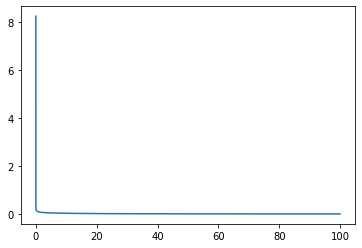

In [66]:
import matplotlib.pyplot as plt

x = np.linspace(1e-06, 100, 10000)

log_mean = 2.8
log_var = 6.0
alpha = np.exp(2.0*log_mean - log_var)
beta = np.exp(log_mean - log_var)
# alpha = 10.0
# beta = 0.1

dist = tfp.distributions.Gamma(alpha, beta, validate_args=True)
print(dist.concentration, dist.rate)

y = dist.prob(x)
log_p = dist.log_prob(x)
print(log_p)

plt.plot(x, y)

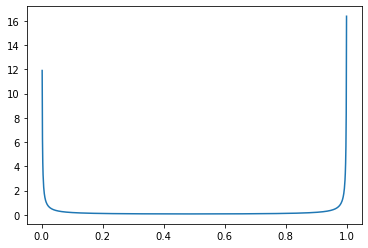

In [67]:
x = np.linspace(0.0, 1.0, 1000)

log_mean = 1.0
log_v = 0.1
alpha = log_v / (1.0 + tf.math.exp(-log_mean))
beta = log_v / (1.0 + tf.math.exp(log_mean))

dist = tfp.distributions.Beta(alpha, beta, validate_args=True)

y = dist.prob(x)
log_p = dist.log_prob(x)

plt.plot(x, y)